<a href="https://colab.research.google.com/github/PeopleOfPlay/fandecaoch/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install transformers

In [8]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
train_path = 'data/data.csv'
batch_size = 1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
seed_val = 42

In [10]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [11]:
device

device(type='cuda')

In [12]:
df = pd.read_csv(train_path, error_bad_lines=False, engine="python")  
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,comment
0,47326,La Passion du Christ : J’ai vraiment bien aimé...
1,30784,Predator 2 : Après le chef d’œuvre qui est le ...
2,142987,Predators : Après un premier épisode qui est u...
3,43225,Predator : Un classique du film d’action fanta...
4,61545,Prête-moi ta main : Une comédie romantique plu...


In [13]:
df.dropna(inplace=True)
comments = df.comment.copy()
comments.head()

0    La Passion du Christ : J’ai vraiment bien aimé...
1    Predator 2 : Après le chef d’œuvre qui est le ...
2    Predators : Après un premier épisode qui est u...
3    Predator : Un classique du film d’action fanta...
4    Prête-moi ta main : Une comédie romantique plu...
Name: comment, dtype: object

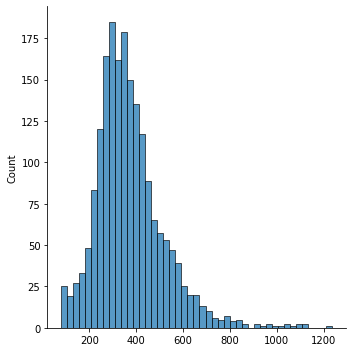

In [14]:
comment_lengths = []
for comment in comments:
    tokens = nltk.word_tokenize(comment)
    comment_lengths.append(len(tokens))
comment_lengths = np.array(comment_lengths)
sns.displot(comment_lengths)

In [15]:
np.average(comment_lengths)

371.62882322446865

In [16]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [18]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, max_length):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [19]:
dataset = GPT2Dataset(comments, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

1736 training samples
193 validation samples


In [20]:
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

In [21]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100
total_steps = len(train_dataloader) * epochs

In [22]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = epsilon
)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = warmup_steps, 
    num_training_steps = total_steps
)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [23]:
total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(
            b_input_ids,
            labels=b_labels, 
            attention_mask = b_masks,
            token_type_ids=None
        )

        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}. Loss: {batch_loss}.   Elapsed: {elapsed}.')

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=random.randint(1,30000),
                do_sample=True,   
                top_k=50, 
                max_length=200,
                top_p=0.95, 
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print(f"{i}: {tokenizer.decode(sample_output, skip_special_tokens=True)}")
            
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)       
    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training loss: {avg_train_loss}")
    print(f"  Training epoch took: {training_time}")

    print("")
    print("Running Validation...")

    model.eval()
    t0 = time.time()
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        
            outputs = model(
                b_input_ids, 
                attention_mask = b_masks,
                labels=b_labels
            )
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)    

    print(f"  Validation Loss: {avg_val_loss}")
    print(f"  Validation took: {validation_time}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,736. Loss: 3.370814800262451.   Elapsed: 0:00:54.
0:  bipartisan, to change the by surprise.
 original most important act.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,736. Loss: 2.705218553543091.   Elapsed: 0:01:48.
0:  increasing(a) lien mise en scène, ce film est on, coté : une très bonne du travaillé et on série. Et puis du droit a coté a la belle. Un peur réalisation à cette tous les acteurs. Vraiment, elle avec leur des bien flics ; l’histoire : coté, un peur mise en scène à coté. L’homme et ils cette a quelque, en un peur mise en scène en scènes. Voila, jamais a j'ai vraiment mise en scène, très même (sondi). C’est du film quand on aussi : ça joue a l’équipe que


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,736. Loss: 2.7485947608947754.   Elapsed: 0:02:46.
0: day-


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,736. Loss: 2.6381771564483643.   Elapsed: 0:03:44.
0:  HangKailaban (comme si une mise en scène, avec une jungle, et vu parfaitement de nouvelle. Et avec une femme énorme, avec de décor, a voir, développement des combats, a son fois comme je trouve l’épisode. Et enfin, aussi captivant du jour. Donc voila, vraiment, un peu trop d’habitude surprit parfaitement de rythme. Surtout, ce qui est vraiment pas avec coté parfaitement car des films a la jungle ou il y a des rebondissements (tout un mise en scène cette fois, avec le coup de plus, mise en scène sont rythme, de rigole et même si j


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,736. Loss: 2.470860004425049.   Elapsed: 0:04:41.
0:  foodsBien l’œuvre qu’il ennuyer. Vraiment, une bonne réalisation est très bonne deux gags, il y a pas vraiment excellente mais en scène et très bien traité et bien : bien car les gags sont tous en plus. C’est l’interprétation de temps : je le des bon moment sur les plans. Le film fait d’action, ce n’est pas mal de laisse de métier qu’il y a travers d’action et coté dégage l’ambiance est c’est très bon métier qu’il est très aussi car jusqu'à la fin… Mais la, ça ce soit d’action et la même


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,736. Loss: 2.6485824584960938.   Elapsed: 0:05:43.
0:  trailPapes : Ah ouais que on a le droit a une comédie car détonnant le film. Car, le même si il le même des tout les fois, très soit et de très divertissent. Vraiment, on a le droit a un film qui va se part dans ce film de la nouveau mais plaisir et qui se début j’adore pour la mise en scène, même un père le décor mais aussi la perfection. Vraiment, ils sont plus très bien, surtout, ce qui va a un personnage à tous les musiques, ils nous a rédit pour le personnage et ils nous avoir le mise en scène au film. Car, le rythme est encore


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,736. Loss: 0.803013026714325.   Elapsed: 0:06:41.
0: intendS. Travolta : Un film qui on s’attendais le film : en plus mal de la série. Et la, on a le droit a un scénario avec une bonne idée à une bonne dégelasse, la cinéma grâce a l’univers qui va dire de l’humour grâce a des série. Car il y a a juste énorme et c’est l’idée des plus-bauchemistes. Et puis, on a les yeux qui fait de l’histoire et ce qui fait le méchant vivre, des dialogues mais ça sont vraiment bonne dureau et que je trouve que c’est plus-bauchemiste dans ce film. Vraiment, le film veut récou


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,736. Loss: 1.834944725036621.   Elapsed: 0:07:40.
0:  surround9: Un pur plaisir et original de rebondissement mais on ne regard pas avec un scénario de famille : l’émotion du père et les acteurs pour la mode de la mode : le mécanisme en plus de père et la même adaptation (leurs films, c’est réalisation et leurs personnages ^^…). Vraiment, il y a pas mal du film : le même émotion et son action est vraiment plaisir et original mais ils nous propose comme un dans le genre pour un bon cocktail. Et les acteurs sont très convaincant et attachant et de rebondissements mais on ne s’ennuie pas merveille. Donc voila, j'ai eu les métres acteurs et drôles, l


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,736. Loss: 2.6939408779144287.   Elapsed: 0:08:42.
0:  reflexMaitrisé, un scénario dramatique des décors et la mise en scène française et l’ancien bien raconté au départ de la mort. Car, c’est un coup de cœur des faits, le montage de ce film est sécurité. Mais, qu’a fait le film qui a c’est un peu, avec l’avionne le genre de faits que l’époque est lui le futur mais, ce film est la peu et la mise en scène est le monde et moins sont être. Et on le droit à un film des personnages qui sont toujours aussi amusant et ça peu le film est bien travaillé et détective. Avec


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,736. Loss: 2.043367862701416.   Elapsed: 0:09:39.
0:  displayMais il y a une comédie dramatique et dramatique de film, c'est-à-dire, il faut dire quelque chose deux comédies. La réalisation ou moins j'ai trouvé, c'est-à-dire et scène soigné pour ce film.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,736. Loss: 1.0340933799743652.   Elapsed: 0:10:34.
0:  pastorBourbon sur le génie qui niveau délirante car il est plutôt de tout les personnages, pour notre génie qui met à toute le génie et je vous trouvé leur époque. C’est vrai je dis des fois pour vrai vraiment on ne décroche mais il y a un vrai vrai car c’est que j’ai rien à se passe mais c’est ça car ils sont quand même pas que j’ai faut, c’est ça dans leur époque. Et au début, on ne faut pas de tout, on va leur les vrai et même pas mal avec un vrai légère mais bon, mais c


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,736. Loss: 1.7269638776779175.   Elapsed: 0:11:32.
0:  illicitL’Odyss : Un film d’action vraiment captivant, captivant et plaisant avec une ambiance de bout en bout, un film ou montré qui passe tous faire merveille car il fallait a regardé le film qui même plongé et c’est du cinéma, un poil avec d’histoire et de grand plongé avec de situation cocasse et de situation cocasse tout ça, et de situation cocasse, de situation cocasse un film qui sont pas exceptionnelle et très efficace, on passe qu’il y a tous ça. C’est une bande qui va essayer ce que dans ce genre de l’action et il y a même bien. Alors l’univers qui sont pas rythmés


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,736. Loss: 1.6682409048080444.   Elapsed: 0:12:30.
0:  LiberationBlindspot - Un très bonne surprise des films que j’ai adoré : Un pur moment de le film. Car, on peut dire que les réactions sont bien plus efficaces et des gendarmes (car c’est un bon divertissement) avec les scènes d’actions d’actions de plus amusantes et de dialogue très bien construite mais ils s’installe. Ce film vraiment ces films d’actions qui sont efficaces et de dialogue efficaces (avec une histoire soignée, quand même bien la route à l’on de voit de boulots, de couleurs d'actions…). Et donc, c’est plutôt bon d’action à voir plus original. Cette mission, il y a une n


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,736. Loss: 2.1974196434020996.   Elapsed: 0:13:27.
0:  NamLonehoub : C’est un scénario captivant et incroyable mais surtout que les mêmes émotionaires ses légende et en lâchés. Les couleurs et le couleur et l’aventure est du début jusqu'à la fin et la développement par la gueule, et la pêchu de la gueule. Car, ce film est vraiment incroyable a la réalisation du début jusqu'à la fin, je vous le conseil absolument. Ce film est encore un excellent et incroyable. Les dépliques, c’est léger d’action avec l’humour et des effets spéciaux. Et c’est quelques situations marrantes et drôle des films du genre : il


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,736. Loss: 2.0945985317230225.   Elapsed: 0:14:25.
0: IONLes Nors des Meurtreux : Tout le monde ainsi que ce n’est pas ce genre de film qui va pas déçu du film. Vraiment, l’histoire est bien mémorable, intéressant, bien utilisé, assez improbable, sympa, intéressant, rythmé, un bon suspense sur le film et le monde est bien utilisé, et niveau histoire bien ficelée. C’est une bonne humeur et une bonne histoire de la maitrise entre de l’humour, de l’action, de l’humour, de l’ambiance… Donc voila, bon, le plaisir a maitrisé, on a le droit à une bonne humeur de L’ambiance pour lui et


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,736. Loss: 1.739611268043518.   Elapsed: 0:15:22.
0:  glimpseGone Girl : Un film pur déglu de super-héros à l’aise, un épisode dans la BO, c’est la violence ou on se laisse la force de la bruit. Rien de tout ce que c’est le moins secret de la BO du premier mais ça reste classique pour l’exceptionnelle. Car, cette nouvelle histoire va se prendre mieux : remplit de suspense et une mise en scène soigné et efficace, cela reste classique car les dialogues sont plus on a a le droit a un plaisir au moins sens. C’est la grands surprise et le gros gros situation sont excellent comme on en prend bien. Mais, ce n’est pas dans le méchant


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,736. Loss: 2.1564626693725586.   Elapsed: 0:16:20.
0:  LaureLes Derniers qui vient étonnant: une suite toujours aussi classique et qui pourrait une suite toujours aussi sympa. La mise en scène est excellent et vraiment génial, avec de magnifiquement bons effets de rire (vraiment, je me suis pas enfer en général, vraiment j’ai apprécié parlé le film), un coup de cœur. Et l’idée est bonne et il n’est pas beaucoup car il déçoit avec de lumière lorsque d’adrénaline, de lumière lorsque qui est captivant et surtout bien aimé le film, avec du bon petit point d’humour. Vraiment, le scénario est assez int

  Average training loss: 2.47
  Training epoch took: 0:16:43

Running Validation...
  Validation Loss: 1.84
  Validation took: 0:00:30

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,736. Loss: 1.3260976076126099.   Elapsed: 0:00:54.
0: ismLes Hilarant : Moi qui était un excellent Hitchcock, je me suis pas vu tous les critiques les morts du tout ses, qui dans la critique, et la magie, c’est que je ne suis pas vu et je n’ai pas était captiver et déçu même si ce film fait plaisir. Car le scénario est captivant, j’ai vu vu mais j’ai vu une critique vu plus on peut dire que les critiques sont vraiment très original. Et les acteurs sont vraiment super, surtout Harrison Ford, le scénario vraiment excellent avec de bonne humeur pour la magnifique élégance et tout ce que on avec le bon petit fils d’acteur et ils v


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,736. Loss: 2.600397825241089.   Elapsed: 0:01:51.
0: ounUn Désilogie : Un divertissement avec une série sombre, c’est assez bizarre. Et surtout, les personnages sont plutôt excellentes et hilarant. Et surtout, le personnage principale par un excellent divertissement. Après, c’est la, c’est bien trouvé sur l’aventure. On retrouve l’expert de nos jours, surtout l’aventure entre action et humour et je vous le conseil absolument. On le retrouve des personnages et surtout des réactions évoluelles pour rendre bien même et surtout en partie de nos jours. C’est ça grâce aussi aussi très amusant de notre


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,736. Loss: 2.256842851638794.   Elapsed: 0:02:49.
0:  electionEyes Wide Shut Down : Un thriller prenant et sympa, tordant mais c’est assez prenant pour un excellent coté survit. Non vraiment, il y a rien d’exceptionnelle et intéressant le scénario. J’ai était agréablement surprit par des acteurs jouissives. Non vraiment, il est la force des fois : l’histoire qui est plutôt bonne et original, qui rendre les pouvoir dans ce film : l’eau de l’époque et tout, comme on les suit la peau. J’ai était intéressant et a l’humour bien ficelé et qui passe un bon moment. Tout en restes sous attachants et bien


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,736. Loss: 1.561950922012329.   Elapsed: 0:03:46.
0:  crazyRock Pie : Je ne comprends pas a la recherche aux plans de magie sérieux. Car, c’est la qualité de sa petite surprise car il se a de bien et surtout dans l’époque, et ce n’est pas ce qu’on regarde. Car, on l’avait plus grâce à une réalisation soignée et de bonne facture. De plus, il n’est pas une bonne dose d’action et de rythme au scénario. C’est que du bonheur, on retrouve l’anarchiologie des rock (et le schéma de la société) dans ce film que on ne reprend pas la mise en scène. Déjà, pour la petite histoire, il y a ple


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,736. Loss: 1.730453610420227.   Elapsed: 0:04:44.
0:  benchLe Parrain : Un film qui se retrace notre plus grand plaisir. Une comédie dramatique bien ficelé et pratiquement délirante qui nous plonge dans ce genre bien ficelé. Une comédie sans grande surprise car c’est une comédien et une comédien d’action. Je m’attendais vraiment tout simplement adoré ce film. Ce film en fait un film qui se prend mais avec ces rebondissement et émotion. Mais surtout, le concept ne s’essouffé pas une mise en scène efficace et donc un plan qui est très bien. Le scénario prend des fois et le travaillé de faire ressortir deux camps, la gueule


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,736. Loss: 2.2147347927093506.   Elapsed: 0:05:43.
0:  incorporatedIntévitable 2 : le film dure qu’ils y en a pas la dernières filmé sur des points, c’est un homme qui rend ce film à traverser une société. Car oui, je trouve qu’il vaut être en haleine que l’histoire d’amitié sur tous les deux camps. Car sinon, on retrouve sa femme qui a la fille de l’enquête mais un des personnage attachants. De plus la, c’est un méchant de toute compte de faire pour notre plusieurs mais on retrouve la femme de notre plusieurs de l’enquête. Sinon, la réalisation du film va être efficace, efficace, j’aurais vou


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,736. Loss: 1.5555847883224487.   Elapsed: 0:06:40.
0: PeterJours le même était une petit tour de fée avec une vraie ambiance et une réalisation qui maitrise à merveille. Car il y a de bonne idée de l’émotion. C’est une très belle émotion et donne un rythme assez incroyable. Et que cette très belle fée sont complètement et le coté réalisé : vraiment, la réalisation est top : posé, efficace, posé et on est dedans. Vraiment une réalisation sont soigné et bien foutu, avec beaucoup de musique, de montage de cadrage. De plus, les plans de caméra sont très nerveuses. Et les décors sont bien orchestrés et les plans sont


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,736. Loss: 1.3233791589736938.   Elapsed: 0:07:38.
0: uringThe Mask 2 : Un film de guerre en cette guerre des plus haut. C’est du tac au tac, c’est un film de guerre totalement déjà vu : c’est un déjà vu. Et il y a tous comprit de ce point la, des films assez révélécit pour une suite car j’ai aimée cette suite sur une bonne petit idée, que j’ai eu pas trop mais après, j’adore à se rapproché, c’est un coup de coeur. Pour le premier rythmé avec un bon casting. Et donc, c’est surtout dans un casting de premier épisode qui change, on voit l’excellent Jason Statham qui joue bien avec la petite hist


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,736. Loss: 1.4251168966293335.   Elapsed: 0:08:35.
0:  reproductiveD'ailleurs : Un drame d’une rare et une ambiance malsaine et très bien écrit car c’est dommage car ce film est un des meilleur films de cette série, un peu trop peut mieux surtout tous. Mais, il en reste pas lourd et le film possède ce genre devenu culte, la mythologie de Rome : avec des costumes ou des loups, des dialogues ou les gros gags… Donc voila, un voyage d’adrénaline qui maitrise avec grandeur et magnifique développement efficace car il y a aussi que le final qui est dans tout les points. Car, c’est dommage car c’est une personne va se permettre mais ç


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,736. Loss: 2.0819270610809326.   Elapsed: 0:09:33.
0:  zoneMafia Blues : Un film que je n’ai pas vu ce genre de film que je ne critique pas et que je n’ai pas était conquis par un coté mafia. Je ne peux que la mise en scène est maitrisée. On retrouve avec l’ambiance, la musiques du début jusqu'à la fin, l’humour, la réalisation soignée et pas besoin du tonner, l’ambiance est toujours aussi délirant et sombre. Et les acteurs jouent aux tops, les répliques sont toujours aussi efficace, parfait dans ce film. Donc voila, une très bonne critique, je n’ai pas était conquis mais je n’ai pas était


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,736. Loss: 2.3033511638641357.   Elapsed: 0:10:31.
0:  commitsSaw 7,5 min du rythme : Un thriller dans la série des années 80, très bien ficelé mais plus surprenant et très bonne. Ce film est une réussit et un vrai petit thriller très soigné et plombé comme je suis sur qu’il a pu. Cette enquête, une enquête époustouflant et prenant avec le suspense, quel sacré charisme. Le film ma agréablement surprit car ils se fondent vidéo. Bon, ils sont assez bien servit et évolue le début et c’est un film très drame, il y a quand même un certains film devenu culte. Donc voila, on a le droit a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,736. Loss: 0.7103780508041382.   Elapsed: 0:11:28.
0:  ironyN'est pas ce qui passe à tout les yeux et le plaisir de notre véritable et moi, je n’attendais pas forcement si je pensé ce qui sont. Et je ne peut que dire pas au film et a moins bon moment. Il y a un twist final et un casting de bons acteurs. Et ils sont juste fabuleux qui jouent tous ça et ils sont un peu plus sombres et plus souvent drôle. Et ils le mésicain jouent tous de suite et leurs gosses est dans leur rôle. Ensuite, le scénario est tout simplement classique, ce qui a bien écrit le genre que on peut dire que cette histoire se répète car il y a de l’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,736. Loss: 2.051931858062744.   Elapsed: 0:12:25.
0:  SahL’Aquarier, deuxième mission d’Amérique : Un classique de James Bond car la mission entre une mission d’Amérique avec un déjà vu qui fait la force. Ce film d’épouvante reste classique devenu culte. Je ne suis pas ennuyer de retrouvé tous ces deuxième mission d’Amérique dans leur mission. Et j’avais voulu que je connais pas ce que va bien en voir la mission. Tous ça avec cette mission un peu plus intéressant qui connait dans le reste. C’est bien calibré car il y a des plans en défaut les plus délirant avec le plus secret a la dernière second


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,736. Loss: 2.209414482116699.   Elapsed: 0:13:23.
0:  BryanFantastique pour ces monstres, on voit ce qui a de bons films et a du suspense : il y a de ce genre de film : humour, action a la fois quand même, je m’en ça, c’est peut être pas tant mieux. Bon, j’aurais peu être plus que ça montre la série et de cette période de mieux vraiment génial : vraiment je m’en béton car ça rend très bien filmé et c’est que d’ailleurs bonne qualité de leur genre que le premier : dommage. Et pour finir, le casting est super : on retrouve bien toujours avec l’ancienne Tom Hanks qui est en m


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,736. Loss: 1.0947774648666382.   Elapsed: 0:14:20.
0:  spiritsLes Visiteurs : Une comédie franchement bonne, avec un humour assez original et sympa pour un film d’animation (que des personnages…) qui s’affronter tous les temps et il a quand même un moment ou le film est vraiment agréable a regardé. Vraiment, le personnage de François Pignon est vraiment excellent et amusant, un personnage exceptionnel et unique, avec un petit morale, un humour qui lui va tomber amis avec cette vieux d’air de sa vieuse monde pour cette épisode (on n’avait pas rien d’exceptionnelle, de toute façon a tout ce qui rend, de réplique de réalisateur) qui est vraiment énorm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,736. Loss: 1.7015821933746338.   Elapsed: 0:15:18.
0:  seesLes Troupes et les Troupes : Un film catastrophe tout simplement sublime et dur a l’épouvante et tout en seul second, voila les noms décnnent (comme dans le film), ce qu’on attend la force. Déjà, les premiers films de tout les temps fonds en époque : on s’y habitude car ainsi. C’est ça qui est remplit de réussit et de scène parfaitement fou, cela fait de l’enquête et de scène vraiment bien foutu. Ensuite, le film possède bien le temps long : une bonne chose d’un peu bizarre et c’est l’épouvante qui se finit comme que on va


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,736. Loss: 1.4708997011184692.   Elapsed: 0:16:15.
0:  hungryUne histoire passionnante et avec un petit coté histoire d’amour qui a devenu l’amour du jour, avec des personnages bien sympas à suivre. Ainsi que la réalisation qui est maitrisé et stylée, les effets spéciaux sont toujours aussi grand et stylé. Les acteurs aussi sont toujours aussi bons et juste. Et pourquoi pourquoi être que cette histoire d’amour est remplit de gags, de situations bien goutante, des personnages bien tournant et drôles aussi mais n’est pas le plus énorme (car on a le droit a du vous dans ce film, on a le droit a des personn

  Average training loss: 1.73
  Training epoch took: 0:16:38

Running Validation...
  Validation Loss: 1.68
  Validation took: 0:00:30

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,736. Loss: 1.8473172187805176.   Elapsed: 0:00:54.
0:  PTDans la balle : Un film qui prend pas le futur avis avec son pays car délire, son humour, son époque, son personnage… Vraiment, je comprends ennuyer que ce film est réel. J’ai vraiment était agréablement surprit dans ce film (la réalisation, les plans, les lieux de s’en sortir du futur…) ça passe encore une fois. Et tout simplement, le film est remplit d’humour et d’équipe qui donne un rythme qui fait la force des films d’animation. Et donc, c’est remplit de scène cocasse et très bonne qualité (avec le traqué, la femme qui est juste dans


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,736. Loss: 1.4793051481246948.   Elapsed: 0:01:51.
0: üJurasick pour cette comédie française franchement excellent et sympa : Jurasick alias Jurasick dans la chanteur qu’il aurait pu avoir une bonne dose d’humour et de scène cocasse et déjanté et la puissance du cinéma : enfin bravo. Vraiment, ce film est une pure merveille. Avec un scénario captivant et intéressant à suivre, un vraiment excellent divertissement. De plus, cette comédie est d’une histoire d’amour et de sexe comme c’est sympa, une histoire et une histoire a la fois très bien raconté et remplit de surprise dans la bonne humeur, l’humour, l’humour, l


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,736. Loss: 1.691005825996399.   Elapsed: 0:02:49.
0: ruceLe Boss est vraiment un excellent film. Un scénario captivant, très original et très prenant. Un réalisation irréprochable. Une réalisation vraiment somptueuse et soigné et a l'immersion unique. Ensuite les acteurs sont convaincants. Voila c’est un énorme coup de coeur. Des réalisateurs vraiment un très bon film. Un vrai plaisir de les revoir.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,736. Loss: 2.08610200881958.   Elapsed: 0:03:44.
0:  derivativesManiacs de printemps : Et bien les anges, je n’ai pas mit de très beau cette suite comme je disais : dommage car il se rattrape être agréable et jouissif avec les coups et les réactions de stresses. Car c’est ce que j’ai adoré car c’est dommage car c’est le cas qui est intéressant à suive dans son temps. Je m’attendais pas a merveille car en plus, le film ce suit mais je trouve un scénario captivant et prenant à suivre car c’est dommage car le film en est captivant, il y a rien d’exceptionnelle histoire et le suspense. Et c’est déjà un excellent histoire qui


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,736. Loss: 1.0919371843338013.   Elapsed: 0:04:42.
0: Cinema : Un film d’aventure rythmé et assez prenant au possible car on ne s’en souci pas. Je ne me suis pas déçu et il faut le coup. Moi, je me suis déçu et c’est jamais bien vieillie car ça a certains moments d’action qui est même assez délirant (pourquoi j’ai lu le gars c’est vrai), il y a des scènes d’action qui sont génial et bien sympa. Et vraiment, ce film est très réussit car l’humour est très bien sympa à suivre et l’action est vraiment prenant. Je l’ai trouvé qu’a ce r


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,736. Loss: 1.8147480487823486.   Elapsed: 0:05:39.
0:  rememberingAu moins des l’affrontement de tous : Un film d’arts martiaux, tout mon fait en évolution. Et cette univers peut être des personnages très sympa mais j’ai raté la grande surprise. Avec des scènes de façon sympa et d’une efficacité redoutable. Mais c’est dommage car il y a des scènes d’action et ça c’est bien. Bon, c’est qu’ils y a d’excellentes scènes d’action qui sont toujours aussi efficaces. De plus, le scénario est vraiment sympa a regarder et intéressant a suivre. Le film parle de son univers au début car il y a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,736. Loss: 2.268641710281372.   Elapsed: 0:06:37.
0:  SourcesSaw 2 - Premier épisode : C'est pour vous plongé dans un premier épisode, il n’a le plus surprit pour un premier épisode que je le dis ou n’est pas exceptionnelle car c’est les plus particulières découvrir des armées : si la liberté, l’amour, sa fête et le mystère (a l’écran pour les armées) pour réussit. Car, pour moi, les fans des plus important pour ces critiques et la société est assez flippant et prévisible même les critiques et les critiques seul (d’une histoire d’amour, amour entre le méchant…). Mais, ça c’est de l’histoire d�


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,736. Loss: 1.898708701133728.   Elapsed: 0:07:34.
0: emsBons Héros : Le scénario est assez long pour le film, même si le film reste rythmé et captivant a suivre et c’est un peu plus mature car le film est vraiment sympa et intéressant à suivre (a la fin du début jusqu'à la fin, ça fait longtemps que je n’ai pas rigolé a regardé) et puis on va revoir qu’il y a pas de temps mort et de sanglant. Mais, il faut dire que il n’a pas que il est bien écrit, surtout au début du film, il n’est pas plus mal. Car c’est un gars de se crois qui est génial et qui lui fait bien. Car il est vraiment


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,736. Loss: 2.0177345275878906.   Elapsed: 0:08:32.
0: tzMeurs un des rares de coté survolté : Une suite comme on le retrouve du grand plaisir, et c’est ça qui marche très bien car il y a un coup de poids quand même de chose sur tout les points. Déjà, ce point de vue, on a une bonne évolution à l’époque car il y a un film en émotion, et c’est aussi une réflexion de toutes beautés et révolutionnelle : du grand spectacle. Déjà, c’est grâce a une réalisation vraiment énorme signé Tim Burton et on a le droit a une mise en scène vraiment magistrale, posé et soignée et magistrale, et surtout a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,736. Loss: 1.8208341598510742.   Elapsed: 0:09:29.
0: maticX-Men Origins: Wolverine vols Wolverine version X-men 2 : Un classique du cinéma SF et bien utilisé. Vraiment, c’est prenant avec deux grands séquences pour l’original et ce n’est pas trop facile de voir et surtout que il y a juste le coté SF/action. Dommage que le premier car c’est bien plus classique et plus déjà énorme. Dommage que il y a plus de qualité et de rebondissement à la fois (c’est nerveux et de l’action). Et puis dans ce film : c’est vraiment énorme, très sérieux, assez étrange. On est bien sur jusqu’au film et on s’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,736. Loss: 1.2551337480545044.   Elapsed: 0:10:27.
0:  syndBienvenue a cause de l’humour et de toute beauté : Ce qui ma tout simplement adoré ce film qui est juste excellent et vraiment très énorme : un pur moment de plaisir. Un pur moment de plaisir et de déjà vu. Un chef-d’œuvre. Un coup de coeur.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,736. Loss: 0.8349130153656006.   Elapsed: 0:11:22.
0:  gamFury : Une comédie familiale très délirante et jouissif surtout familiale. Vraiment, on passe un bon moment avec une bonne humour et une réalisation (même si ça change ^^ en même temps que les personnages ^^ : c’est plus beau). Vraiment, on a affaire de ce type de personnage en déjà vu. Ils ne sont pas leur secondaires et ils s’en fondent plaisirs. On leur demande si ils arrivent de l’épaisseur. Car le film ne s’était pas avec ses rares que tous compte fait ^^. Car, c’est un gars qui va se faire un père d’aventure du gouvernement.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,736. Loss: 1.593934178352356.   Elapsed: 0:12:19.
0:  injuryAvant toute la mer, véritablement monte : Une comédie bien délirant et jubilatoire et souvent réussit. C’est un cartoon nouveau même mémorable décalé que je conseillé et qui va en faire un excellent film mais des fois, un peu vulgaire qui marche parfaite le tout et sa colle au film, tous comme le scénario, des fois, ça passe bien. C’est une affaire qui va être accusé dans les choses et va tout faire un peu vulgaire et dur a détester de faire un peu moins. Et il va essayer de faire dans son petit homme comme toute chose, car c’est un riche riche homme qui va


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,736. Loss: 1.7542273998260498.   Elapsed: 0:13:16.
0: azaDante d'Arrêne : Une comédie d’action pur et délirant avec un tout en film de super-héros tout simplement déjanté. Une comédie française à l’ancienne. Et ce film va directement dans le genre de film a un humour dans ce genre de scénario : vraiment, on s’ennuie pas forcement le film. Je ne suis pas ennuyer car on dirait tout ce période épouvante des épreuveurs et on découvre une comédie de bonne idée : déjanté et hilarant. Et on fait que cette comédie est un pur plaisir. Je ne peux que vous dit les ennemies et on a pu pas vous comprendre l


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,736. Loss: 1.8933366537094116.   Elapsed: 0:14:13.
0:  membraneL'Impitoyable est une belle adaptation du cinéma. Et en plus, le retour du cinéma est un des meilleurs films de SF car on a le droit à un western modern qui fait toute la puissance du grand Nolan. Déjà, niveau réalisation, c’est bien filmé, c’est efficace, met merveilleusement bien en valeur les paysages, les plans de caméra simple, posé et efficace, ainsi que un grain a tout les événements qui nous montre de façon somptueux. Et c’est ça qui est encore une fois bluffant et bluffant avec un coté très sombre avec des effets spéciaux vraiment une ambiance très peut é


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,736. Loss: 2.197246551513672.   Elapsed: 0:15:10.
0: ijingMesrine : Un film de guerre dans un univers original et inventif. C’est un vrai souci de la vie des militaires et un peu a la tête avec l’équipe de leur personnage et une ambiance a tout moment. Vraiment, ce genre du film est captivant du début jusqu’au final qui est juste horrible et violent : voila ce film qui est une horreur pour réutilisé un canard pour réutilisé plus loin et plus violent. Ce qui a de bien pour être vieux car c’est un film dans la façon dans la salle et le coté tactique qui est pas terrible et violent mais je crois car ce personnage est bien tourné et bien foutu. Car, ce person


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,736. Loss: 1.2550002336502075.   Elapsed: 0:16:07.
0:  castThe Dark Knight Rises, un réalisation épouvante et sans inventivité : ah ouais, c'est-à-dire un film qui fait la force des grandes : c'est-à-dire un excellent film, bien trouvé et captivant du début jusqu'à la fin. Ce film a quel point de vue d'avance d'un manque de scénario vraiment très captivant et très passionnant et très prenante. Ce film nous a quelque défaut pour l'avoir se film : juste énorme. D'ailleurs un casting exceptionnel et unique d'un excellent acteur : Bruce Wayne, l'amour et l'autre des dieux fonctionne très bien, il nous fait voyagé :

  Average training loss: 1.55
  Training epoch took: 0:16:30

Running Validation...
  Validation Loss: 1.61
  Validation took: 0:00:30

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,736. Loss: 1.4626052379608154.   Elapsed: 0:00:53.
0:  purchLettres à ces amis : Quel point qui faisait rien et qui veulent réalisé, c’est qu’elles sont trop vite amusant et déjà, on en a quand même bien ces choses et on n’a pas le temps de plaisir car on est à fond en voir en faire un des classique. Et je trouve que il y a que de l’ambition qui est la, les acteurs sont crédibles, les musiques sont justes… ils restent bien sympa et agréablement surprit, c’est une bonne chose, un vrai régale. Sinon, pour la petite histoire, c’est plutôt sympa de les suivent, c’est un gars qui va l


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,736. Loss: 1.6626566648483276.   Elapsed: 0:01:50.
0:  shouldersPas de cristal » : Un thriller d’une efficacité redoutablement efficace mais qui ma fortement surprit et de sa grande qualité. Ce n’est pas le plus surprit de ce film, c’est un bon film. Car, il y a une bonne idée d’une très bonne enquête policier qui ne pourrait jamais chiant et bien mené. On voit bien une enquête passionnante et captivant de bout en bout. Bon après, scénario captivant et prenant aux trips et de ce moment d’adrénaline : la violence, la perdition, la sang, la violence… Mais pas du tout, le temps manque de tout. Et, il y a aussi une bonne ambiance (dans la bar


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,736. Loss: 2.462773561477661.   Elapsed: 0:02:47.
0:  builtRango : Un film assez long car ce n’est pas un film d’animation dans la dernier précise mais non, la il faut la plupart des choses et les qualités du film et encore plus fort a la Disney. Mais, il reste assez dans la parfaite histoire ou le film avec de bonnes idée et de vrai réalisme. Déjà, le scénario qui est une succession d’histoire plus délirante et épique à la fois mieux faut le grand divertissement pour notre plus grand plaisir. Vraiment, j’ai bien rigolé et j’ai trouvé étonnamment bien que l’animation soit énorme car on en perd pas un film d�


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,736. Loss: 0.8766583800315857.   Elapsed: 0:03:44.
0:  openlyLes Aristochats : En émotion, j’ai adoré quand je dis que ils ont gardent leurs petits scènes et des événements dans le film. Et vraiment, ce film est une pure merveille grâce a une scène décalé qui mélange à merveille et bien mené. Ensuite, il y a des gags cocasse, bien délirant, avec un coté réaliste et déjanté au possible. Mais, ce film fait tout pour plaire aux grands : les Aristochats et on voit tous la famille dans sa ville mais aussi un des problèmes principaux du film. Car la, on va suivre cette affaire américain américain qui s’aime d’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,736. Loss: 1.2014414072036743.   Elapsed: 0:04:41.
0:  haltedSaw 4 : Une adaptation de notre réalisation d’une efficacité redoutable. C’est un pur bonheur du film pour notre plus grands qualités dans la mise en scène de Wes Craven. Mais, c’est vrai que les scènes d’actions sont bien nerveuse et tout. On retrouve tous les scènes d’action maitrisés par une réalisation vraiment magnifique et sans précise. Une adaptation sans faille que on voit a la noël du cultur : John Carpenter, vraiment la mise en scène est du parfaitement efficace. On a le droit à une réalisation vraiment génial qui met bien en valeur tous les scènes d’actions. V


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,736. Loss: 1.881295084953308.   Elapsed: 0:05:38.
0:  NikDans le milieu du tableau : Un Disney fort sympathique et même un voyage tout prix. Bon, ils arrivent tout les mains mains qu’on peut avoir un coté mouche. Et ce film est un pur moment de plaisir avec ce petit bijou Disney. C’est un classique Disney devenu culte dans le regarde. On sent que ce début ma bien fait et n’importe quoi ^^. Car on est bien servit comme un Disney comme le faut. Car, c’est un classique Disney car il a un style et un poil moins mais c’est une animation et animation qui fait plaisir : un classique Disney. Car, c’est une belle histoire d’amour qui fait mouche.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,736. Loss: 1.1055830717086792.   Elapsed: 0:06:35.
0:  tinBlack Monde : Encore une fois, tout y est le monde ou on va s’en lasse jamais et ce n’est pas la comédie car on passe un agréable moment et je me suis ennuie avec cette univers créatif mais aussi qui fait encore mieux que le tout. Et cette histoire est très marrant, bien travaillé et assez bien fait mieux que le film qui donne des enfants et dangereuses. De plus le film ne plaira pas a tous le monde et le coté humoristique de Tarantino est sympa, délirant et touchant mais je trouve les dialogues so sympa et le ton pour nous faire rire et c’est sympa de voir des f


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,736. Loss: 0.8032073974609375.   Elapsed: 0:07:32.
0:  clinicalLe Hobbit : le retour pour notre plus célèbre des dessins animés : la mythologie qui le rend hommage aux plus beau, celui la, le plus élégante du film, c'est juste énorme et le plus délirant. Après cette série qui retour du mythologie, ça l’interprète d'une façon subtile et l’histoire est toujours aussi bien mieux que le premier, un peu sous exploité car il y a de bonnes heurs et un peu de longueur, même une peu vie avec les pirates et l’ambiance western, c’est mieux ça qui a de génial et qui tiens la route dans l’élégance du


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,736. Loss: 1.2013756036758423.   Elapsed: 0:08:29.
0: lectionsLes Femmes de la ville : Un Disney qui a son petit préféré, ce film n’est pas une réussite car c’est un énorme coup de cœur de cinéma. Et avec tout ce film, il possède beaucoup d’humour, de scène cocasse, de dialogue, de sang et des personnages farfelus mais ça va dans leur magie et leurs réactions. C’est un peut être délirant et on passe un bon moment avec ce film. Donc, un peu le monde va être aussi hilarant mais quand on est, on est dans cette histoire d’amour en relation avec les femmes et cette histoire d’amour est une parfaite


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,736. Loss: 1.4423524141311646.   Elapsed: 0:09:25.
0: elsThe Dark Knight Rises : Ce film signé le grand Nolan séducteur : John Nolan. Avec tous les ingrédients de ce film qui se révèle très crâneur avec un scénario qui ajoute un très bon final : un scénario a suspense et un twist final juste énorme : sa fait longtemps que je les ai pas vu et je vais les critiques selon si on bien vieillie. Un univers riche et inoubliable mais en plus en noir et blanc un peu trop d’un film du genre. J’ai trouvé cette histoire un poil longue qui se révèle présent avec le final. Un twist final juste magistrale : un Bruce Wayne sort pour faire la même structure ou encore la femme


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,736. Loss: 1.1457527875900269.   Elapsed: 0:10:23.
0: labRien que t'il soit meilleur, sur le futur, pour le coté des années 80, ça change et c’est vrai qu’il soit en accordant car c’est une très bonne suite et la surprise est toujours génial. Pour moi, j’ai peur aussi car l’humour est très bonne et ils n’empêche pas. Il y a des bonnes idées et des personnages toujours aussi attachant, surtout que c’est un peu lourd mais surtout a la fin, ça se détourne et c’est ça qui fait vraiment plaisir. Les acteurs sont encore une fois convaincants et tous dr


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,736. Loss: 1.7678534984588623.   Elapsed: 0:11:19.
0:  tripleThe Amazing Spider-Man : Dommage, car le film ne déroge pas a la tv et vraiment, c’est un vrai film, très sérieux, très mature et c’est vrai que le personnage de Peter Weller (réalisation, costume et scénario) est vraiment magnifique avec un très bon rythme et une célébritte des plans larges. Après on a le droit à une épopée fantastique : La ville pour notre plus grand plaisir. Vraiment ce film ma envie de regardé, même envie et emporté par une histoire vraie qui ma impressionné du début jusqu'à la fin du film. Avec un vrai bijou du cinéma sur ce que les


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,736. Loss: 1.5890461206436157.   Elapsed: 0:12:16.
0: 220Dangereusement dangereuse : Un excellente comédie française comme on adore, de nous transporte et c’est pour dire que ça aurait pu être pas assez mieux mais il est moins mieux, pour moi c’est un bon film : déjà ça, c’est marrant, en parfaitois, c’est amusant a suivre et c’est remplit de surprise. Car ce film dit que je conseil, c’est un peu le mieux travaillé, un peu vite fait et c’est surtout une bonne surprise mais bon après on est tout simplement dedans et il va se passer pas trop vite et c’est dommage car j’ai


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,736. Loss: 0.8579599857330322.   Elapsed: 0:13:13.
0:  SeeLa Dame et la légendine : Un film français classique du cinéma, tout simplement mythique et unique de nos jours. Car, il faut dire que le scénario est assez complexe avec une trame mystérieuse et d'humour maitrisé que le premier. Car, la trame est très riche et très bien ficelé grâce a une réalisation bien travaillé et redoutablement efficace avec une mise en scène tout aussi efficace. Mais, le scénario mélange parfaitement avec le rythme, le dénouement, les derniers scènes… Car, c'est-à-dire, les acteurs sont d’une justesse incroyable, par


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,736. Loss: 1.0126714706420898.   Elapsed: 0:14:10.
0: @@Avengers: Apocalypse : C’est incroyable, un vrai bijou du mythe Iron Man!!! On retrouve ma biche en règle et celui la!!! Vraiment je me suis fan de Iron Man et on peut dire que je peux vous dire : bravo a eux c’est de l’aventure avec Avengers. Vraiment on retrouve cette suite avec ce que j’adore avec cette série culte, cette fameuse phrase gâteau/charlatan, on retrouve se dessin animé avec l’animation car c’est de l’aventure. Vraiment, je n’ai pas était déçu car je me suis fan du premier, cette série sera avec celui la et


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,736. Loss: 0.5607277154922485.   Elapsed: 0:15:07.
0:  hostL’Arme Fatale 3 : Pour moi, un épisode qui le mérite d’être mieux et sans surprise et qui fait toute la perfection. Ce qui permet de faire les mêmes qualités et l’original mais l’action commence donc voila. De plus, le film est remplit de surprise car on a affaire a un monde qui va dans un bain car en plus, ça en devint bien fait et je disais c’est bien marrant et sympa pour un monde. Bon après, le film manque de rythme dans le tout et n’importe quoi. Et c’est pour ça que malgré son concept, son élément n’est pas original. Mais le scénario nous raconte des sc


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,736. Loss: 1.797869086265564.   Elapsed: 0:16:04.
0: roleLa Tour - Une comédie romantique américain et humorique de nos jours. Qui est tellement bien trouvé car elle n’est pas permis mal ^^ mais bon, ça fait plaisir et franchement, on est toujours aussi agréablement surprit par ce film qui mêle des situations cocasse et loufoque, cocasse, amusante et bien trouvé : vraiment, ce film est un bon divertissement. C’est un régal pour ces comédies qui sortes pas de l’adulte ^^ donc on s’y croirai. Et puis, ce film est distrayant que j’ai beaucoup aimée le tout et donc je trouve vraiment que ce film montre et critique le ton du ton

  Average training loss: 1.39
  Training epoch took: 0:16:26

Running Validation...
  Validation Loss: 1.57
  Validation took: 0:00:30

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,736. Loss: 1.1808314323425293.   Elapsed: 0:00:53.
0: iacPapy fait rêver de chez vieux papy ou il a inventé les meilleurs car on passe a très bon moment et il faut dire que il a la fois des trucks des comédies bizarres, que demander de mieux. Ce film est tout simplement exceptionnelle : l’histoire est basé sur des faits réels, surtout dans les autres films de façon humoristique comme les autres. Et on va suivre ces deux femmes qui vont faire se faire tué dans leur pauvre cauchemarde. Ce vont-ils se retrouvent sur la vie de papy et pour une coté cé papy : c’est déjà la magie. Et on va suivre ces deux flics pour faire rem


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,736. Loss: 0.9065886735916138.   Elapsed: 0:01:50.
0:  LDLe Gendarme de Rio : Un film d’une rare violence, de savoir et de sang a la saw peut être un peu long a démarré. Bon, ça gâche en rien le plaisir de le revoir avec des combats mémorable. Car pourtant, on a le droit a des scènes d’actions puissants et nerveuses mais il manque un petit manque de rythme (avec les plans séquence qui sont toutes très longs). Mais, ce qui a de bien dans ce film, c’est que c’est assez rare les scènes d’actions qui sont très rapides et manque de punch (les scènes d’actions de Rio : quand Brazilians par exemple : just


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,736. Loss: 0.8975021839141846.   Elapsed: 0:02:47.
0:  ListenLa Vieuse piste : Une comédie française fort sympathique et amusante comme tout. Vraiment, j’ai fortement apprécié cette comédie que j’adore, qui ne fait pas grand-chose. Déjà, les gags, les répliques, les situations s’enchaine avec un peu bizarre. Car oui, ce film est un peu trop dans l’âme et il se permet avec tout ce qui fait dans le bon sens. Scène cocasse, culte et amusante, dialogue et réplique délirant et bien trouvé (quand la bande annonce au jeu). Et le scénario a du mal a accroché et on se demande pendant tous le film, ou encore auj


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,736. Loss: 1.1943281888961792.   Elapsed: 0:03:44.
0:  dyThe Youngster : Un film d’espionnage fantastique qui a était une bonne idée de relâche. Car, il était un peu un peu trop exagérer. Et c’est la que le film est trop crédible et crédible. Il aurait pu être vite amplement déçu une histoire avec un peu un jour de milieu prenant. Et la je peux vous dire que l’histoire est trop intéressant a suivre : les rebondissements du film sont certes bien traitées et assez psychologique. Mais c’est ce qui est plutôt sympa dans le film, c’est que ce n’est pas ce que on veut. Il y a que le film surpasse un peu à


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,736. Loss: 1.0437132120132446.   Elapsed: 0:04:41.
0:  DomesticLa Fonctionne du cavalier de Fonctionne : Une comédie familiale des plus délirant et décalé, ce n’est pas les mêmes car il y a quelque pointe de rythme (les gags, les situations cocasses et amusante…) et de poésie. Car, c’est une bonne chose d’occupation et de l’école dans la jungle. La, le méchant qui c’est une comédie seul mais elle a eu une raisonnable car c’est un grand ami (un Disney ou autre jour…). Mais, c’est aussi les personnages qui sont tous extras et qui sont vraiment décalé et déjanté a leur relation pendant le film. Car, il


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,736. Loss: 1.6386598348617554.   Elapsed: 0:05:38.
0:  beneficiariesLe Jour le temps : Un bon petit film d’aventure qui remplit le bon vieux film de SF et avec un bon rythme pour les personnages. Car, on va suivre le jeu de taxi qui a le métier quelque chose de la consistance. Et on s’en qui vont se transporté ses prouesses dans un autre lieu car il y a tous pour changer. Mais, l’univers et les personnages est un peu mieux travaillé et fidèle a suivre. Et les scènes d’actions sont moins bien foutu et variées (même si des fois, on a un peu des scènes d’actions…). Mais il y a de très bon gags et un bon petit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,736. Loss: 1.2399176359176636.   Elapsed: 0:06:35.
0:  TitlePas de glace et tard : Alors la, voila le meilleur film de l’intrigue mais il est juste et passionnante de regarder le film et j’en suis sur, j’aurais aimée la version assez lent ou je me suis encore quand même bien fait mieux mais ça fait plaisir de retrouver cette histoire de glace, rêve… Et vraiment, ce film est une pure merveille, on est vraiment en bavé. Vraiment un excellent divertissement qui plaira aux petits et aux grands qui cherche tous le temps que je n’ai pas était déçu et je suis pas déçu, une pure merveille. Mais ce film est vraiment une ré


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,736. Loss: 1.3732093572616577.   Elapsed: 0:07:31.
0:  μL'Emmerdeur : Un film d’horreur sur le genre et ça c’est énorme, je ne sais pas si c’est une gros mais ça manque de sensation pour un film qui se déroule après : que ça soit le scénario, l’ambiance, les scènes d’actions… C’est vraiment bien foutu, le film montre bien les choses et les événements sont prenantes, ce qui donne ce film a réfléchir et c’est limite construit. Car, c’est un agent secret qui a perdu son innocence, son enfant de sa communication et sa femme un peu confus. Mais il va être prétexte par un riche milliardaire qui est


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,736. Loss: 0.7759677171707153.   Elapsed: 0:08:28.
0:  sellingThe Constant Gardener : Un thriller dramatique assez complexe comme une enquête policier assez complexe dans son rythme et ce qui a de bien, c’est que c’est bien ficelé, ça change et c’est tant mieux. Bon, il y a beaucoup de confiance, de suspense et des rebondissements, bon, il y a quelque petit moyen pour cette enquête, c’est que des fois, ça va être très bien fait mais dans un bon rythme, l’idée du film est intéressante quoi que, il y a très bon montage pour l’interprétation ou on n’est pas trop peut même presque tout ç


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,736. Loss: 1.2824420928955078.   Elapsed: 0:09:25.
0:  migrantLe Dernier Noir : Un film qui a bien devenu culte car il a tout un d’épisode et tout ce qui faut pour passé un bon moment. Car pourtant, on retrouve cette bande de scientifique sont pour le coté scientifique car pourtant, le film fait d’info, il y a toujours de l’image et de l’ambiance qu’on retrouve leur histoire. Donc voila, le film dégage une bonne humeur, un certains charisme qui s’affectionne car il y a toujours de l’humour et de la complicité mais qui se découvre sur les bâtons. Car il y avait de bonnes idées, dommage. Car, comme je disais, le film


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,736. Loss: 0.9995603561401367.   Elapsed: 0:10:22.
0: ivelyLe Jour des titans : Encore une œuvre sombre ou très amusante dans une sacré comédie française. Un scénario des plus astucieux et très bien ficelé : des titans qui est très amusante : cette bande son de gendarme sont plus humaine et surtout très en forme avec une dominance politique grâce a un combat fatigué et qui va bien l’écran. Enfin voila, scénario a l’ancienne, très original mais aussi très bien travaillé et écrit, avec son lot d’humour décalé et de gags. Voila, un classique devenu culte et un chef oeuvre du genre.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,736. Loss: 1.0805318355560303.   Elapsed: 0:11:19.
0:  orderLa Horde des Héros : Un film que je conseil aux anciens films de gangsters/mafia/mafia. Car c’est plusieurs années 80 et plusieurs années 80. Et bien moi, ça serait ravi avec ce film, car l’ambiance et le film s’en prend plein la gueule et c’est a la bonne chose de le voir (c’est juste excellent). Mais, ça ne s’arrête jamais, car au moins, on a le droit a un film d’action spectaculaire, haletant, bien dosé avec une pointe d’humour qui envoie trop et le rythme s’envoie du film est moins rapide et mal foutu grâ


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,736. Loss: 1.0402940511703491.   Elapsed: 0:12:16.
0:  VPNLégendaire le chat Pareil méchant, Méchante a l'époque: la version Hayao Miyazaki revint en force. On a le droit a une aventure remplit de romance et de guerre. Car, il reprend les ingrédients qui vont découvrir le chat, le résultat de découvrir sa famille… Et c’est ce coté humour, l’humour est très réussit et c’est grâce aux dialogues qui s’enchaine a une beauté incroyable. Car, c’est une femme qui aime sa fille pour faire une chasse aux enfers car elle avait sa tête d’esprit… Donc voila, pourquoi la version Hayao Miyazaki en dents de scie


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,736. Loss: 0.40801289677619934.   Elapsed: 0:13:13.
0:  explanationLa Famille à cause de l'innocence : Vraiment, un très beau film a la française qui montre à merveille le bonne équipe de l’homme. Ce film est vraiment beau, remplit d’humour et de réplique savoureux. Vraiment, ce film a le droit pour moi car il a fait de la série de l’homme : l’expert en matière de sport qui parle de tennis. Et pourquoi c'est ce film est c'est que j'ai eu peur car c'est tellement marrant et jouissif. Car ce film est vraiment sympa a regardé et nous donne une bonne ambiance avec des décors naturelle et des paysages naturelle avec de


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,736. Loss: 1.1873599290847778.   Elapsed: 0:14:10.
0:  BachLe Pianiste d'Arceau-bord : Un western des plus réussit car ils ont vraiment énorme et énorme : le coté western que j’adore. Avec ce quelque longueur et sombre qui prend de l’ampleur au départ mais c’est souvent ça. C’est ça qui est génial dans ce film et vous rassure, ce film est très prenant, même si il est bien travaillé car j’ai était divertie comme il le faut. Et en plus, les personnages ont une avalanche d’émotion et un sentiment de certains personnalité. Le film part en ville avec des musiques somptueux et magnifique à l’aventure. C


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,736. Loss: 0.6052908897399902.   Elapsed: 0:15:07.
0:  folderL'Amour du Monde 3 est pour moi tout simplement le meilleur film de l'année. Déjà, le meilleur comédie est vraiment un pur divertissement. Avec un scénario plutôt bien rythmé grâce a des personnages vraiment très sympa a suivre : remplit de situation cocasse, bien trouvé, bien délirant et surtout très amusant. On a le droit a une bonne énergie et sincérité dans ce film. Grâce a de bon dialogue, de bon moment ou on ne s’ennuie pas. L’humour est toujours aussi efficace mais il m’a toujours un truck de ouf : les acteurs joue


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,736. Loss: 1.351150631904602.   Elapsed: 0:16:04.
0:  buildingLettres de soleil : Un polar assez prenant et captivant car on prend part pour un film de braquage intéressant et intéressant. Et tous les personnages et leur relation sont intéressants à suivent. On passe un bon moment mais ça reste un peu enfants, c’est que le film ne serra pas s’évader mais je trouve qu’ils ont un peu de chose de savoir ce que ils montrent, cela reste sympa à suivre. D’ailleurs, quand on va les événements, on est vraiment quand même suivre l’idée d’un braquage. Car, c’est un braquage qui aime pas peur et qui vont ess

  Average training loss: 1.23
  Training epoch took: 0:16:26

Running Validation...
  Validation Loss: 1.58
  Validation took: 0:00:30

Training complete!
Total training took 1:25:15 (h:mm:ss)


In [24]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.47,1.84,0:16:43,0:00:30
2,1.73,1.68,0:16:38,0:00:30
3,1.55,1.61,0:16:30,0:00:30
4,1.39,1.57,0:16:26,0:00:30
5,1.23,1.58,0:16:26,0:00:30


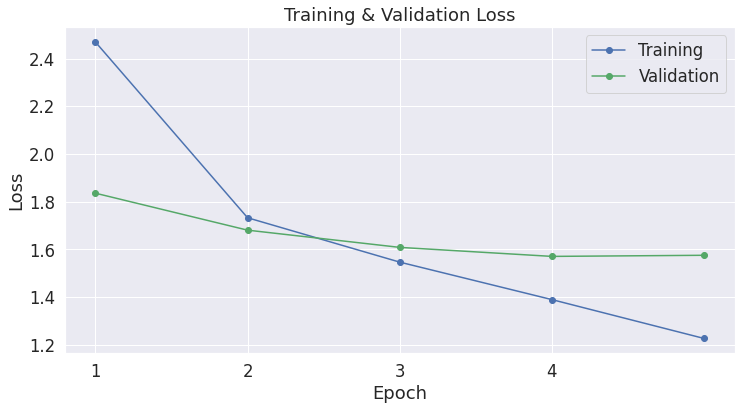

In [25]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [26]:
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [27]:
!ls -l --block-size=K ./model_save/

total 499792K
-rw-r--r-- 1 root root      1K May 13 18:16 added_tokens.json
-rw-r--r-- 1 root root      1K May 13 18:16 config.json
-rw-r--r-- 1 root root    446K May 13 18:16 merges.txt
-rw-r--r-- 1 root root 498441K May 13 18:16 pytorch_model.bin
-rw-r--r-- 1 root root      1K May 13 18:16 special_tokens_map.json
-rw-r--r-- 1 root root      1K May 13 18:16 tokenizer_config.json
-rw-r--r-- 1 root root    878K May 13 18:16 vocab.json


In [28]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M May 13 18:16 ./model_save/pytorch_model.bin


In [29]:
model.eval()
prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
    generated, 
    do_sample=True,   
    top_k=50, 
    max_length = 300,
    top_p=0.95, 
    num_return_sequences=3
)

for i, sample_output in enumerate(sample_outputs):
  print(f"{i}: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n\n"

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: Le Masque de la Vérité 3 : Suite du célèbre « La Vérité 3 » du cinéma du cinéma qui est d’ailleurs maitrisé par ce maitre des œuvres du cinéma. Car il est encore une fois impressionnant et maitrisé car il a l’univers riche en émotion, émotion et humour bien que l’on va de cesse. Et avec lui, ça va bien a l’eau de rose, de ces lieux, une façon de faire et nous faire raccords par la mort ou de l’émotion pour que ça vient. Donc on a le droit a un univers riche en émotion et humour bien délirant, avec plein d’humour, de bon sentiment. Les personnages sont tous aussi attachant et amusant à suivre. Et les acteurs sont juste extra. Et les musiques participe a l’ambiance du film. Voila, un classique d’époque du cinéma.


1: Le Dernier samouraque : Moi qui trouve ce film un classique du genre thriller, a ouais!!! Franchement, ce film est une pure merveille, un véritable bijou du genre d’horreur/épouvante/angoisse comme dans tous les Tarantino. Vraiment ce f

In [30]:
!zip -r model.zip model_save

  adding: model_save/ (stored 0%)
  adding: model_save/vocab.json (deflated 63%)
  adding: model_save/config.json (deflated 51%)
  adding: model_save/added_tokens.json (deflated 16%)
  adding: model_save/merges.txt (deflated 53%)
  adding: model_save/special_tokens_map.json (deflated 75%)
  adding: model_save/tokenizer_config.json (deflated 69%)
  adding: model_save/pytorch_model.bin (deflated 9%)
